# <span style="color:blue">Title: Introduction to </span><span style="color:red">Single-Cell RNA-Seq (scRNA-seq) Data Analysis</span>

# <span style="color:blue">Competency</span>
* ## Become proficient in single cell RNA-seq data analysis from HuBMAP.

# <span style="color:blue">Objectives</span>
* ## Import HuBMAP preprocessed data into an anndata object with the Python library scanpy.
* ## Filter cell outliers based on the number of genes expressed for raw data.
* ## Normalize and log transform raw data.
* ## Generate clusters and visualize via UMAP dimensional reduction.
* ## Find cluster-specific marker genes with scanpy.

# <span style="color:blue">Install the required </span><span style="color:red">Python libraries</span><span style="color:blue"> to conduct the </span><span style="color:red">scRNA-seq analysis</span><span style="color:blue">.</span>

In [1]:
############################################################################
# Install the required Python libraries to conduct the scRNA-seq analysis. #
############################################################################

# Install scanpy
!pip install scanpy -q

# Install pybiomart
!pip install pybiomart -q

# Install leidilang
!pip install leidenalg -q

# Install pandas
!pip install pandas -q

# <span style="color:blue">Load required </span><span style="color:red">Python libraries</span><span style="color:blue">.</span>

In [2]:
###################################
# Load required Python libraries. #
###################################
#
# scanpy: handle our AnnData
import scanpy as sc

# pandas: handle dataframes and export them into files
import pandas as pd

# pybiomart: obtain the biomart annotations for Homo sapiens
import pybiomart

# os: use the operating system dependent functionality to manipulate paths 
import os

# leidnalg: general algorithm for methods of community detection in large networks 
import leidenalg

# <span style="color:blue">Obtain the </span><span style="color:red">biomart annotations</span><span style="color:blue"> for </span><span style="color:red">Homo sapiens</span><span style="color:blue">.</span>
* ## Retrieve gene annotations from ensembl biomart.

In [3]:
# Obtain the biomart annotations for Homo sapiens.

annot = sc.queries.biomart_annotations("hsapiens",
                                       ["ensembl_gene_id",
                                        "hgnc_id",
                                        "hgnc_symbol",
                                        "start_position",
                                        "end_position",
                                        "chromosome_name"],).set_index("ensembl_gene_id")

# <span style="color:blue">Read HuBMAP's data file for</span> <span style="color:red">HBM538.PHSC.677</span><span style="color:blue">.</span>
* ## scRNA-seq (10x Genomics) [Salmon]
* ## Thymus
* ## Publication Date
    * ## 2020-08-22
* ## Last Modified
    * ## 2020-08-22
* ## Reference
    * ## HBM538.PHSC.677. Hubmapconsortium.org. [accessed 2023 Dec 17]. https://portal.hubmapconsortium.org/browse/dataset/3ac0768d61c6c84f0ec59d766e123e05.

In [4]:
###############
# HuBMAP Data #
###############

# Path to the directory with the data to be analyzed.
hubmap_file = "/ocean/projects/see240003p/shared/HBM538.PHSC.677_cluster_marker_genes.h5ad"

# Read in the H5AD file into an AnnData object.
#
#   adata.X
#       stores the count matrix.
#
#   adata.obs
#       stores metadata about the observations (cells).
#
#   adata.var
#       stores metadata about the variables (genes).
#
#   adata.uns
#       stores any additional, unstructured information we decide to attach
#       later.

adata = sc.read_h5ad(filename=hubmap_file)

# Create a directory for the results.

In [5]:
# Create the directory scanpy_results

# If the directory scanpy_results doesn't exist, it will be created.
if(os.path.exists('scanpy_results') == False):
    os.mkdir('scanpy_results')
# Othewise it will display a message that it exists.
else:
    print('The directory scanpy_results exist.')

#  Change the working directory in the Jupyter Notebook
os.chdir('scanpy_results')

The directory scanpy_results exist.


# <span style="color:blue">Display the </span><span style="color:red">adata (anndata object)</span><span style="color:blue"> for inspection of the available data.</span>

In [6]:
# Display the adata (AnnData object) for inspection of the available data.

print('\nHuBMAP Data: %s\n' % (hubmap_file))
print(adata)

# Display the count matrix.

print('\nCount matrix in adata.X')
print(adata.X)

# Display the metadata about the observations (cells).

print('\nMetadata about the observations (cells) in adata.obs')
print(adata.obs)

# Display the metadata about the variables (genes).

print('\nMetadata about the variables (genes) in adata.var')
print(adata.var)


HuBMAP Data: /ocean/projects/see240003p/shared/HBM538.PHSC.677_cluster_marker_genes.h5ad

AnnData object with n_obs × n_vars = 13203 × 9646
    obs: 'n_genes', 'n_counts', 'leiden'
    var: 'n_cells', 'mean', 'std'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

Count matrix in adata.X
[[-0.03735224 -0.03880377 -0.03694997 ... -0.2328844  -0.02699587
  -0.0288792 ]
 [-0.03735224 -0.03880377 -0.03694997 ...  0.09687786 -0.02699587
  -0.0288792 ]
 [-0.03735224 -0.03880377 -0.03694997 ...  0.44369975 -0.02699587
  -0.0288792 ]
 ...
 [-0.03735224 -0.03880377 -0.03694997 ... -0.2328844  -0.02699587
  -0.0288792 ]
 [-0.03735224 -0.03880377 -0.03694997 ... -0.2328844  -0.02699587
  -0.0288792 ]
 [-0.03735224 -0.03880377 -0.03694997 ... -0.2328844  -0.02699587
  -0.0288792 ]]

Metadata about the observations (cells) in adata.obs
                  n_genes  n_counts leiden
GCCAGCATCATGCCCT     2712

# <span style="color:blue">Create the list with the Ensembl IDs from adata.var.index.</span>

In [7]:
# Obtain the list of Ensembl IDs with the version number.
ensembl_ids_w_version = adata.var.index

# Display the list of Ensembl IDs with version number.
print(ensembl_ids_w_version)

# Has the adata.var.index the same elements in the same order as ensembl_ids_w_version.
print('\nensembl_ids_w_version = adata.var.index:', (ensembl_ids_w_version == adata.var.index))

Index(['ENSG00000211753.4', 'ENSG00000211699.2', 'ENSG00000211695.2',
       'ENSG00000211701.2', 'ENSG00000211698.2', 'ENSG00000233306.2',
       'ENSG00000211776.2', 'ENSG00000211778.2', 'ENSG00000211786.3',
       'ENSG00000211791.2',
       ...
       'ENSG00000215548.2', 'ENSG00000158482.10', 'ENSG00000216331.2',
       'ENSG00000248155.1', 'ENSG00000236397.3', 'ENSG00000237973.1',
       'ENSG00000248527.1', 'ENSG00000225972.1', 'ENSG00000233646.1',
       'ENSG00000285287.1'],
      dtype='object', length=9646)

ensembl_ids_w_version = adata.var.index: [ True  True  True ...  True  True  True]


# <span style="color:blue">Obtain the HUGO symbols for the Ensembl IDs of our data.</span>

In [8]:
# Define an empty list named genes_hugo_symbols
genes_hugo_symbols = []

# Define an empty list named ensembl_ids_wo_version
ensembl_ids_wo_version = []

# Initialize count_gene to one.
count_gene = 1

# Display the column titles.
# Traverse the list of Ensembl IDs with the version number.
for gene in ensembl_ids_w_version:
    # Split the Ensembl ID using the dot as the symbol.
    ensembl_gene_id_split = gene.split('.')
    # Handling Exceptions
    try:
        # Add the Ensembl ID without the version number.
        ensembl_ids_wo_version = ensembl_ids_wo_version + [ensembl_gene_id_split[0]]
        # Get the updated HUGO symbol using just the Ensembl ID without the version.
        hugo_symbol_updated = annot.hgnc_symbol[ensembl_gene_id_split[0]]
        # Add the HUGO symbols to the list.
        if(type(hugo_symbol_updated) == float):
            genes_hugo_symbols = genes_hugo_symbols + [ensembl_gene_id_split[0]]
            #print("%5d) %20s\t%20s" % (count_gene, gene, ensembl_gene_id_split[0]))
        else:
            genes_hugo_symbols = genes_hugo_symbols + [hugo_symbol_updated]
            #print("%5d) %20s\t%20s" % (count_gene, gene, hugo_symbol_updated))
    # If an error occurs assign the ensembl id instead of the hugo symbol.
    except:
        #
        genes_hugo_symbols = genes_hugo_symbols + [ensembl_gene_id_split[0]]
        #print("%5d) %20s\t%20s" % (count_gene, gene, ensembl_gene_id_split[0]))
    # Increase the counter variable count_gene by one unit.
    count_gene += 1

# <span style="color:blue">Confirm that the list of HUGO symbols has the same length as the original Ensembl IDs list.</span>

In [9]:
# Display the length of the genes_hugo_symbols list.
print('Length of ensembl_ids_w_version = %d & length of genes_hugo_symbols = %d.' % (len(ensembl_ids_w_version), len(genes_hugo_symbols)))

Length of ensembl_ids_w_version = 9646 & length of genes_hugo_symbols = 9646.


# <span style="color:blue">Add the columns with Ensembl IDs with versionnumber, Ensembl IDs without version number, and HUGO symbols to our adata.var object.</span>

In [10]:
# Convert the list of Ensembl IDs with version number into a pandas dataframe column.
col_ensembl_ids_w_version = pd.DataFrame(ensembl_ids_w_version, columns=['ensembl_ids_w_version'])

# Convert the list of Ensembl IDs without version number into a pandas dataframe column.
col_ensembl_ids_wo_version = pd.DataFrame(ensembl_ids_wo_version, columns=['ensembl_id_wo_version'])

# Convert the list of HUGO symbols into a pandas dataframe column.
col_hugo_symbols = pd.DataFrame(genes_hugo_symbols, columns=['hugo_symbols'])

# Change the index of the new columns DataFrames to match the index of the 'adata' DataFrame.
col_ensembl_ids_w_version = col_ensembl_ids_w_version.set_index(adata.var.index)
col_ensembl_ids_wo_version = col_ensembl_ids_wo_version.set_index(adata.var.index)
col_hugo_symbols = col_hugo_symbols.set_index(adata.var.index)

# Add the new columns into the adata.var
adata.var['ensembl_ids_w_version'] = col_ensembl_ids_w_version['ensembl_ids_w_version']
adata.var['ensembl_id_wo_version'] = col_ensembl_ids_wo_version['ensembl_id_wo_version']
adata.var['hugo_symbols'] = col_hugo_symbols['hugo_symbols']

adata.var.index = col_hugo_symbols['hugo_symbols']

# Display the metadata about the variables (genes).
print(adata.var)

                 n_cells      mean       std ensembl_ids_w_version  \
hugo_symbols                                                         
TRBV28                23  0.019618  0.525205     ENSG00000211753.4   
TRGV3                 25  0.022770  0.586796     ENSG00000211699.2   
TRGV9                 27  0.021017  0.568792     ENSG00000211695.2   
TRGV1                 31  0.025864  0.632187     ENSG00000211701.2   
TRGV4                 64  0.063155  1.147382     ENSG00000211698.2   
...                  ...       ...       ...                   ...   
MTCO1P12              27  0.024917  0.695426     ENSG00000237973.1   
MTATP6P1            2072  2.075905  5.992122     ENSG00000248527.1   
MTND1P23             990  0.823387  3.535604     ENSG00000225972.1   
OR52T1P               12  0.013594  0.503549     ENSG00000233646.1   
ENSG00000285287       13  0.013410  0.464341     ENSG00000285287.1   

                ensembl_id_wo_version     hugo_symbols  
hugo_symbols                    

# <span style="color:blue">Filter the data</span>
* ## The HuBMAP data has already been filtered, so we don't have to perform these steps.
* ## For this reason, the code in this section is commented out, but is included for orientation purposes when dealing with raw data.

In [11]:
###################
# Filter the data #
###################

#    Filter cell outliers based on counts or numbers of genes expressed. Only keep cells with at least min_genes=200 genes
# expressed. This is to filter measurement outliers, i.e. “unreliable” observations.

# Reference
#     Batut B, Hotz H-R, Tekman M. 2023. Clustering 3K PBMCs with Scanpy. [accessed 2023 Jul 4].
# https://training.galaxyproject.org/training-material/topics/single-cell/tutorials/scrna-scanpy-pbmc3k/tutorial.html.

#    This step is important because low-quality cells can result from a number of factors, including cell damage during
# dissociation or failure during library preparation (such as ineffective PCR amplification or reverse transcription,
# Ilicic et al. 2016). These low-quality cells typically have low total counts, few genes that are expressed, and high
# mitochondrial or spike-in proportions. Using cells of low quality can lead to inaccurate results in downstream analysis.

# Display the information contained in the variable adata (AnnData object).
#print('\nInformation contained in the variable adata (AnnData object)')
#print('\n', adata)

# Filter out  cells with less than 200 genes expressed.
#
#   min_counts : Optional[int] (default: None) Minimum number of counts required for a cell to pass filtering.
#
#    min_genes : Optional[int] (default: None) Minimum number of genes expressed required for a cell to pass filtering. 
#
#sc.pp.filter_cells(adata, min_genes=200)
#print('\nFilter out  cells with less than 200 genes expressed.')
#print('\n', adata)

# Filter out the genes that are detected in less than 3 cells.
#
#    min_cells : Optional[int] (default: None) Minimum number of cells expressed required for a gene to pass filtering.
#
#sc.pp.filter_genes(adata, min_cells=3)
#print('\nFilter out the genes that are detected in less than 3 cells.')
#print('\n',adata)

# <span style="color:blue">Normalization and log transformation</span>
* ## The HuBMAP data has already been normalized and log tranformed, so we don't have perform these steps.
* ## For this reason, the code in this section is commented out, but is included for orientation purposes when dealing with raw data.

In [12]:
# Normalize the data matix to 10,000 reads per cell, to make the counts comparable among cells.
#    This step is important because in single-cell RNA sequencing data, systematic differences in sequencing
# coverage between libraries are frequently found (Stegle, Teichmann, and Marioni 2015). They usually result
# from technical variations in the effectiveness of cDNA capture or the efficiency during PCR amplification
# across cells, which are caused by the challenge of obtaining consistent library preparation with little
# starting material. In order to compare the expression profiles of different cells, these differences are to
# be eliminated through normalization. As a result, any detected heterogeneity or differential expression
# within the cell population is due to biology and not by technical biases.
#
# Reference: Chapter 2 Normalization. Bioconductor.org. [accessed 2023 Jul 19].
# http://bioconductor.org/books/3.14/OSCA.basic/normalization.html.

#sc.pp.normalize_total(adata, target_sum=1e4)

# Logarithmize the data.
#    Log-transformation favors genes with large relative differences, so this method is more conventional.

#sc.pp.log1p(adata)

# <span style="color:blue">Principal component analysis (PCA)</span>

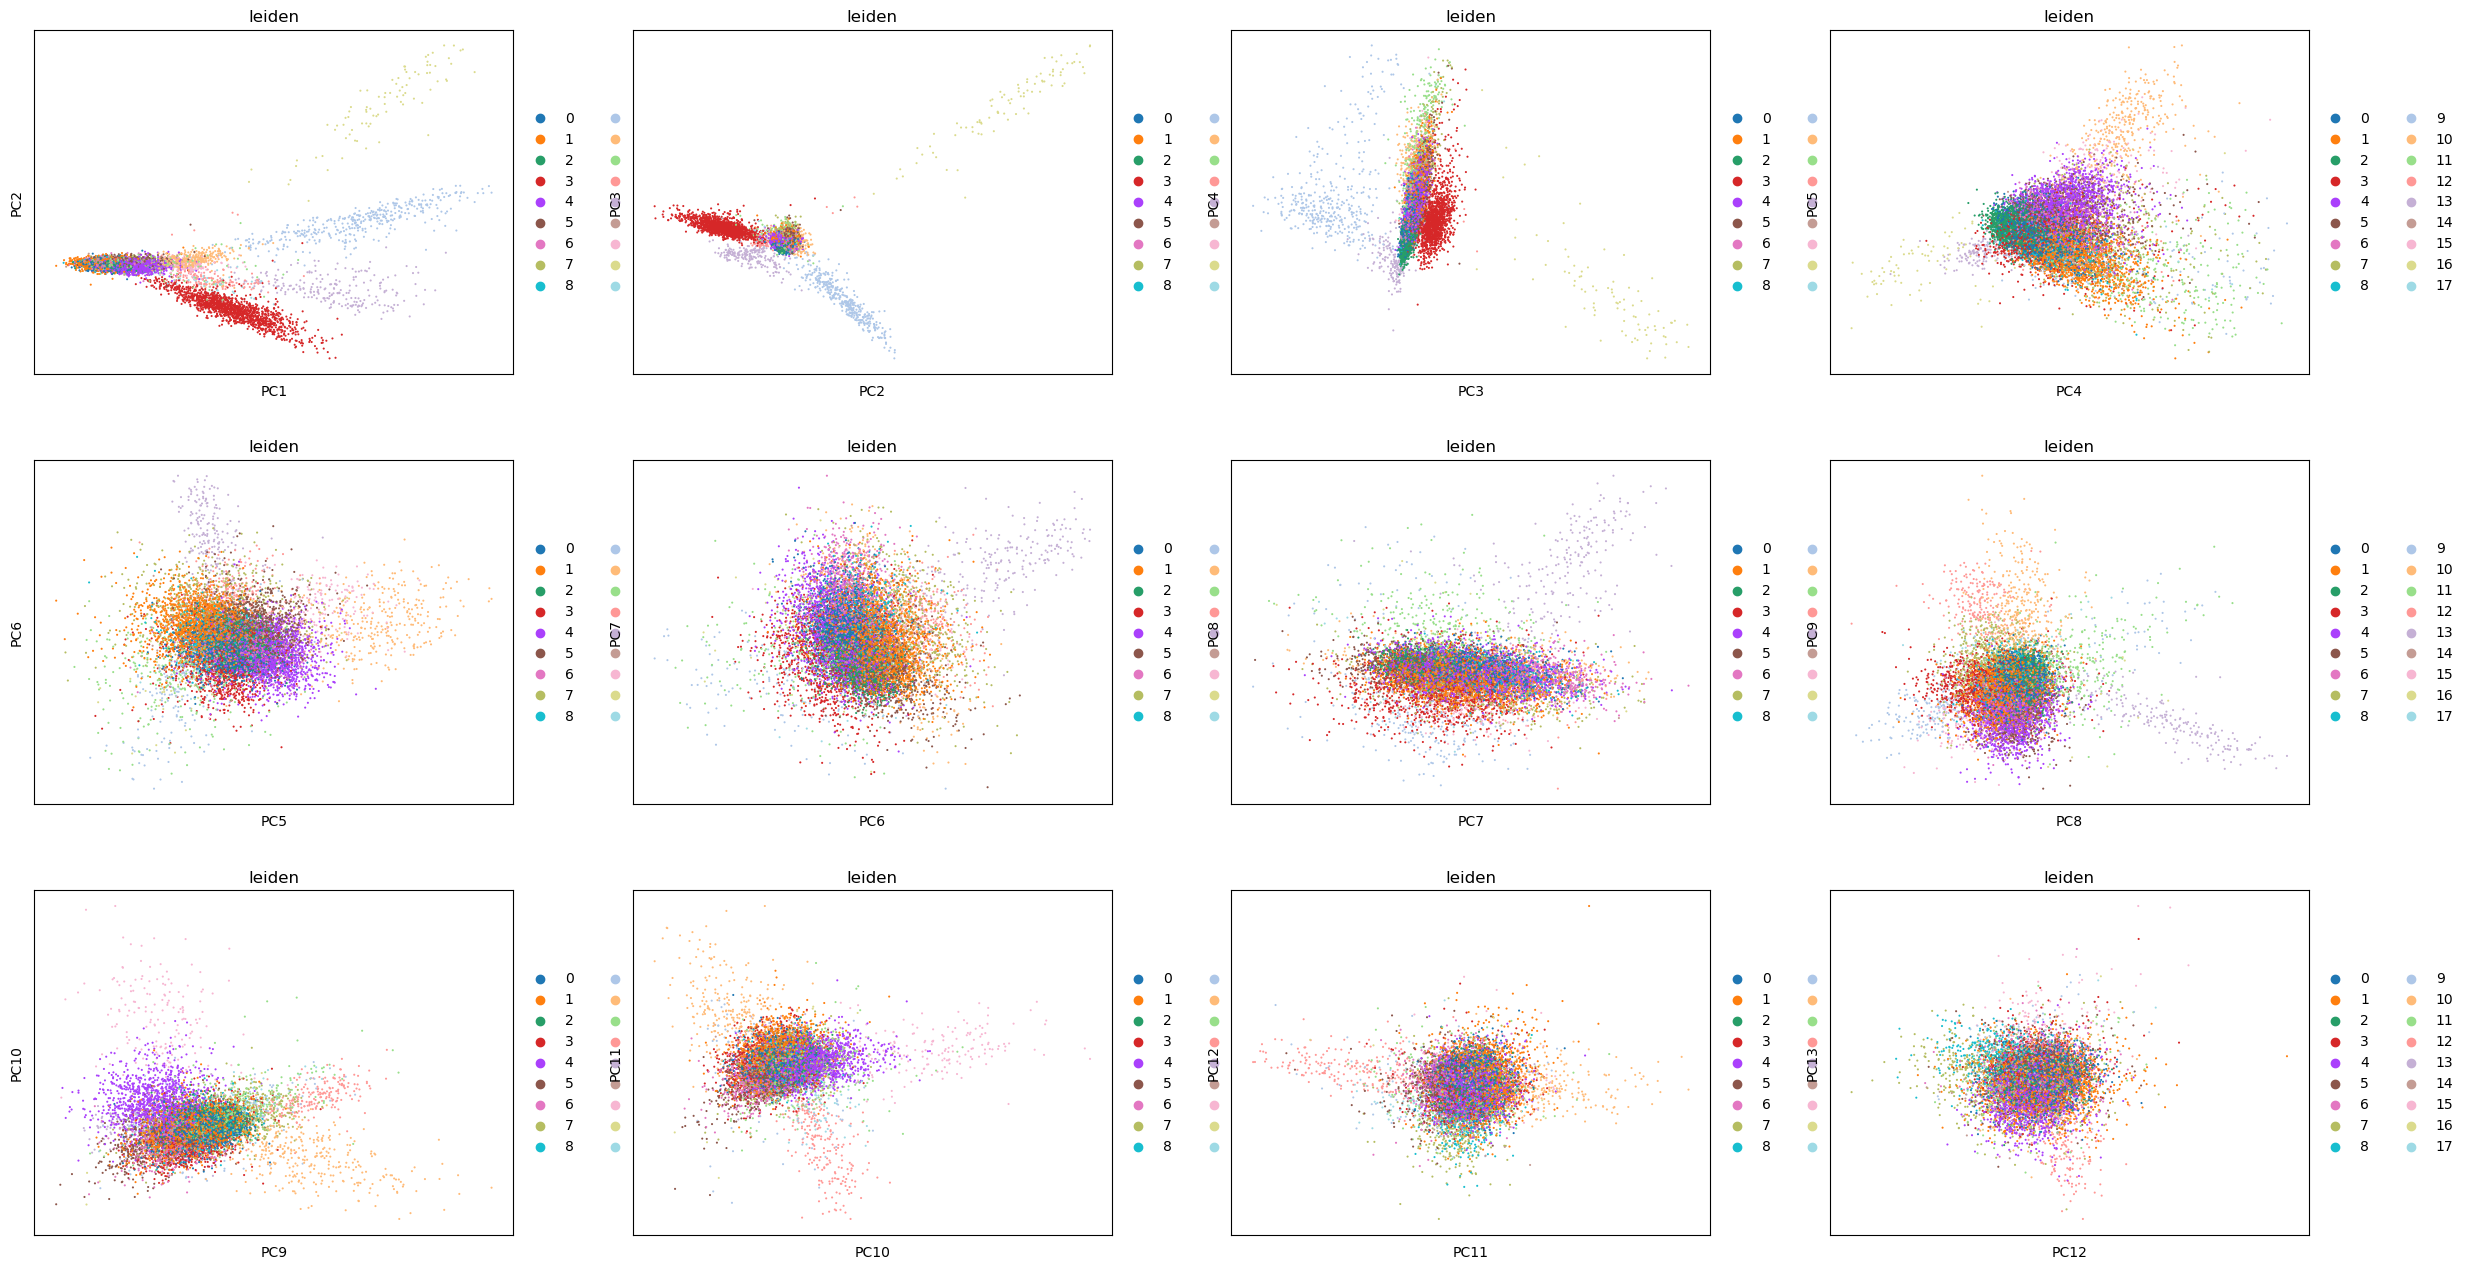

In [13]:
######################################
# Principal component analysis (PCA) #
######################################
#
#   Reduce the dimensionality of the data by running PCA, which reveals the main axes
# of variation and denoises the data.

# Reference
#     Batut B, Hotz H-R, Tekman M. 2023. Clustering 3K PBMCs with Scanpy. [accessed 2023 Jul 4].
# https://training.galaxyproject.org/training-material/topics/single-cell/tutorials/scrna-scanpy-pbmc3k/tutorial.html.
#    
#    The top PCs are likely to represent the biological signal and the noise are
# concentrated into the later PCs.

sc.tl.pca(adata, svd_solver='arpack')

# Display the to 12 PCs.

sc.pl.pca(adata, color='leiden', components=['1,2', '2,3', '3,4', '4,5', '5,6', '6,7',
                                             '7,8', '8,9', '9,10', '10,11', '11,12','12,13'], save="_plot.png")

# <span style="color:blue">Elbow plot</span>

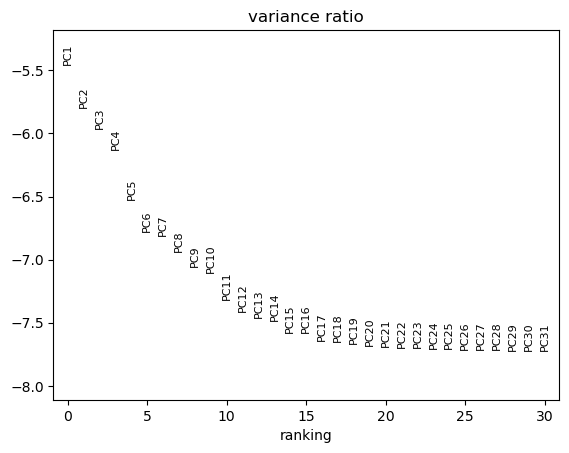

In [14]:
##############
# Elbow plot #
##############
#
#   Inspect the contribution of single PCs to the total variance in the data. This gives us information
# about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g.
# used in the clustering function sc.tl.leiden.
#
#    log  : log is a parameter for plotting on logarithmic scale.
#
#    save : save is a parameter to specify a string that will be appendeded to the default filename
#           pca_variance_ratio of the plot.

sc.pl.pca_variance_ratio(adata, log=True, save="_elbow_plot.png")

# <span style="color:blue">Compute the neighborhood graph</span>

In [15]:
###################################
# Compute the neighborhood graph #
###################################
#
#   Compute the neighborhood graph of cells using the PCA representation of the
# data matrix.
#
#    n_neighbors : int (default: 15)
#
#    n_pcs : Optional[int] (default: None)
#
#    method : Optional[Literal['umap', 'gauss', 'rapids']] (default: 'umap')

sc.pp.neighbors(adata)

# <span style="color:blue">Cluster the neighborhood graph</span>

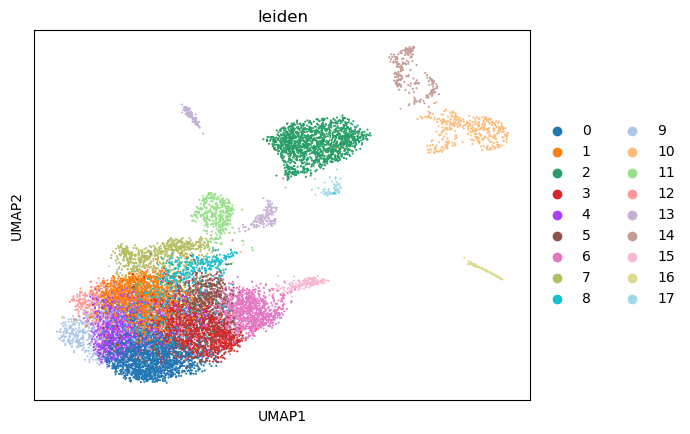

In [16]:
##################################
# Cluster the neighborhood graph #
##################################

#   The Leiden graph-clustering method (community detection based on optimizing
# modularity) by Traag *et al.* (2018) is recommended. This will cluster the
# neighborhood graph of cells computed in the previous step. Clustering summarizes
# the data and allows us to describe the population heterogeneity in terms of
# discrete and easily understandable labels.
#
#    resolution : float (default: 1) is a parameter value controlling the
#                 coarseness of the clustering.
#
sc.tl.leiden(adata, resolution = 1.3)

#    Plot the clusters.
#
#    color : Keys for annotations of observations/cells or variables/genes 
#
#    save : save is a parameter to specify a string that will be appendeded to the default filename
#           umap of the plot.
#
sc.pl.umap(adata, color='leiden', save="_plot.png")

# <span style="color:blue">Find marker genes per cluster using the </span><span style="color:red">t-test method</span><span style="color:blue">.</span>

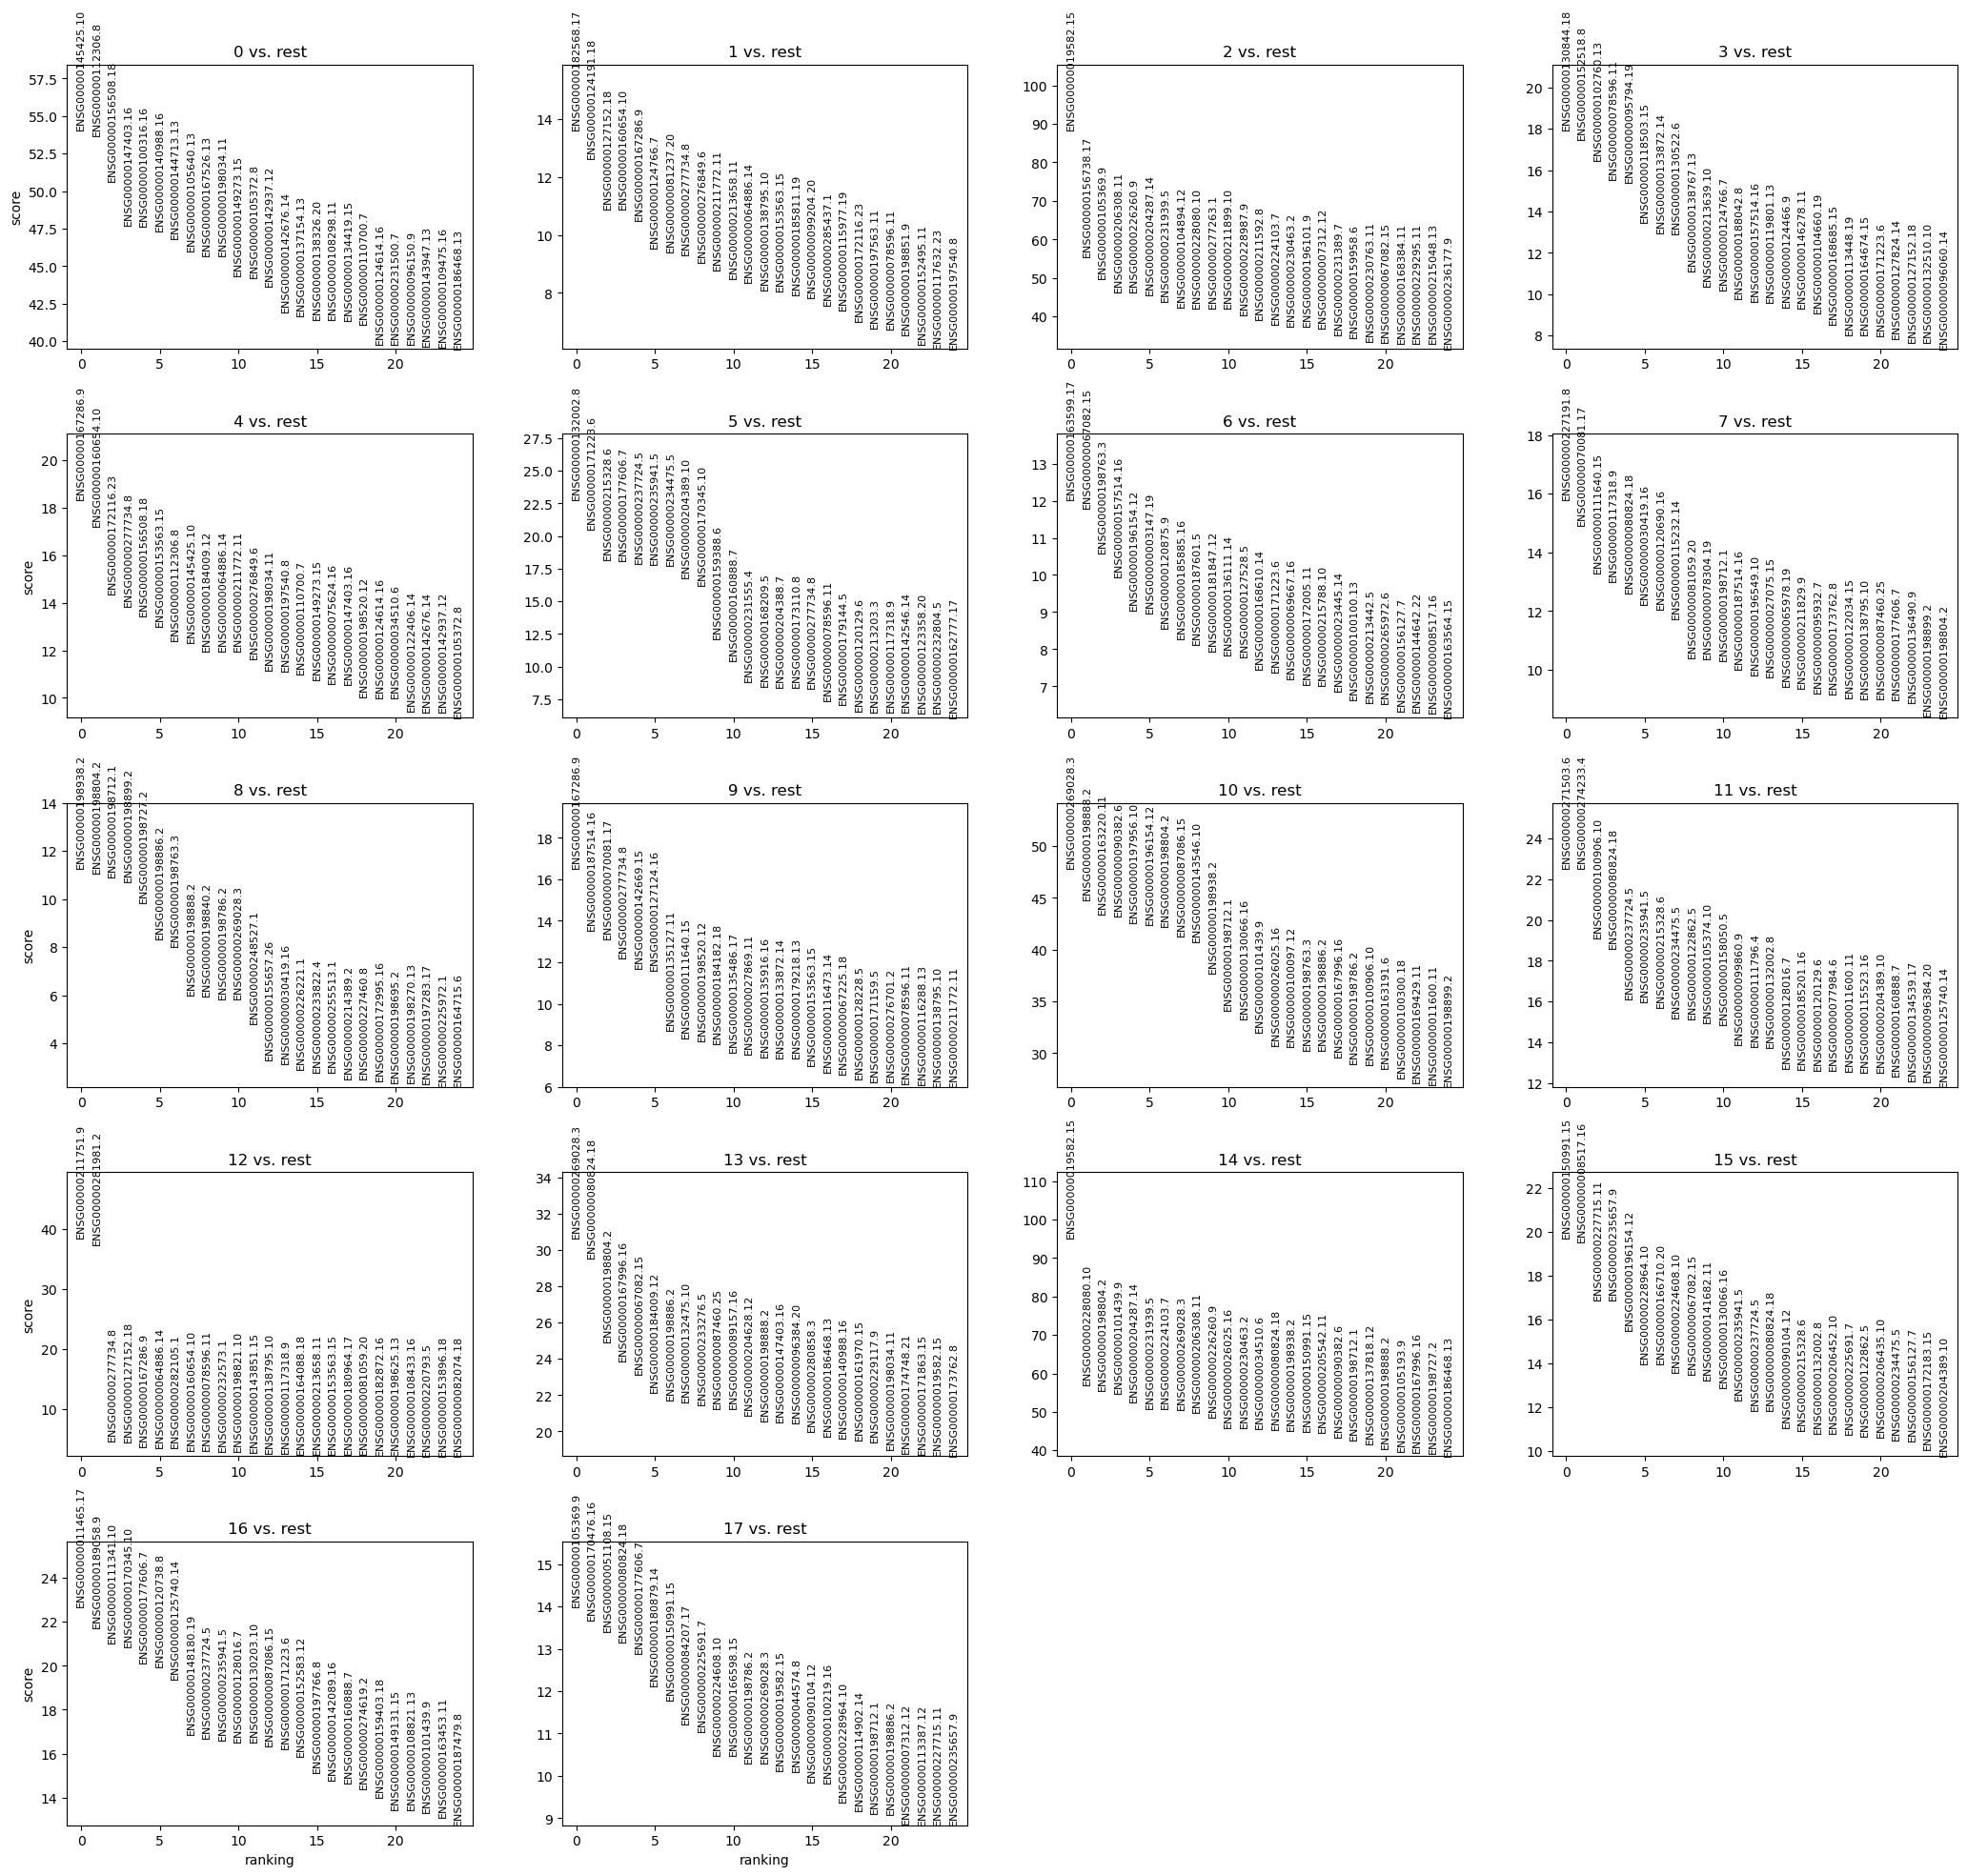


Differential Genes for Cluster 0
                     names     scores  logfoldchanges          pvals  \
0      ENSG00000145425.10  54.062653        1.245264   0.000000e+00   
1       ENSG00000112306.8  53.712582        1.255521   0.000000e+00   
2      ENSG00000156508.18  50.655636        1.098429   0.000000e+00   
3      ENSG00000147403.16  47.734753        0.986079   0.000000e+00   
4      ENSG00000100316.16  47.698425        1.322006   0.000000e+00   
...                   ...        ...             ...            ...   
17718  ENSG00000204287.14 -36.595737       -7.219622  1.920032e-277   
17719   ENSG00000234475.5 -38.662613       -2.078189  4.794108e-293   
17720   ENSG00000215328.6 -39.800858       -2.109948  6.813253e-310   
17721   ENSG00000237724.5 -41.986900       -2.201779   0.000000e+00   
17722   ENSG00000235941.5 -42.351440       -2.217856   0.000000e+00   

           pvals_adj  
0       0.000000e+00  
1       0.000000e+00  
2       0.000000e+00  
3       0.000000e+00

In [17]:
#################################
# Find marker genes per cluster #
#################################

#   Compute a ranking for the highly differential genes in each cluster. The
# simplest and fastest method to do so is the t-test.
#
# t-test
sc.tl.rank_genes_groups(adata, groupby='leiden', method='t-test', corr_method='benjamini-hochberg')

#    Rank genes for characterizing groups.
#
#    n_genes :  int (default: 20) is the number of genes to show.
#
#    sharey  : bool (default: True) Controls if the y-axis of each panels should
#              be shared. But passing sharey=False, each panel has its own y-axis range.
#
#    save    : save is a parameter to specify a string that will be appendeded to the default filename
#              rank_genes_groups_leiden of the plot.
#
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, save="_t_test_plot.png")

# Get rank DE genes for clusters 0 - 17.
de_df_c0 = sc.get.rank_genes_groups_df(adata, group="0")

de_df_c1 = sc.get.rank_genes_groups_df(adata, group="1")

de_df_c2 = sc.get.rank_genes_groups_df(adata, group="2")

de_df_c3 = sc.get.rank_genes_groups_df(adata, group="3")

de_df_c4 = sc.get.rank_genes_groups_df(adata, group="4")

de_df_c5 = sc.get.rank_genes_groups_df(adata, group="5")

de_df_c6 = sc.get.rank_genes_groups_df(adata, group="6")

de_df_c7 = sc.get.rank_genes_groups_df(adata, group="7")

de_df_c8 = sc.get.rank_genes_groups_df(adata, group="8")

de_df_c9 = sc.get.rank_genes_groups_df(adata, group="9")

de_df_c10 = sc.get.rank_genes_groups_df(adata, group="10")

de_df_c11 = sc.get.rank_genes_groups_df(adata, group="11")

de_df_c12 = sc.get.rank_genes_groups_df(adata, group="12")

de_df_c13 = sc.get.rank_genes_groups_df(adata, group="13")

de_df_c14 = sc.get.rank_genes_groups_df(adata, group="14")

de_df_c15 = sc.get.rank_genes_groups_df(adata, group="15")

de_df_c16 = sc.get.rank_genes_groups_df(adata, group="16")

de_df_c17 = sc.get.rank_genes_groups_df(adata, group="17")

print('\nDifferential Genes for Cluster 0\n', de_df_c0)

print('\nDifferential Genes for Cluster 1\n', de_df_c1)

# Save results in a Tab Delimited File
#
# Cluster 0
de_df_c0.to_csv('diff_expr_cluster_00_method_t_test.txt', sep='\t', index=False)
#
# Cluster 1
de_df_c1.to_csv('diff_expr_cluster_01_method_t_test.txt', sep='\t', index=False)
#
# Cluster 2
de_df_c2.to_csv('diff_expr_cluster_02_method_t_test.txt', sep='\t', index=False)
#
# Cluster 3
de_df_c3.to_csv('diff_expr_cluster_03_method_t_test.txt', sep='\t', index=False)
#
# Cluster 4
de_df_c4.to_csv('diff_expr_cluster_04_method_t_test.txt', sep='\t', index=False)
#
# Cluster 5
de_df_c5.to_csv('diff_expr_cluster_05_method_t_test.txt', sep='\t', index=False)
#
# Cluster 6
de_df_c6.to_csv('diff_expr_cluster_06_method_t_test.txt', sep='\t', index=False)
#
# Cluster 7
de_df_c7.to_csv('diff_expr_cluster_07_method_t_test.txt', sep='\t', index=False)
#
# Cluster 8
de_df_c8.to_csv('diff_expr_cluster_08_method_t_test.txt', sep='\t', index=False)
#
# Cluster 9
de_df_c9.to_csv('diff_expr_cluster_09_method_t_test.txt', sep='\t', index=False)
#
# Cluster 10
de_df_c10.to_csv('diff_expr_cluster_10_method_t_test.txt', sep='\t', index=False)
#
# Cluster 11
de_df_c11.to_csv('diff_expr_cluster_11_method_t_test.txt', sep='\t', index=False)
#
# Cluster 12
de_df_c12.to_csv('diff_expr_cluster_12_method_t_test.txt', sep='\t', index=False)
#
# Cluster 13
de_df_c13.to_csv('diff_expr_cluster_13_method_t_test.txt', sep='\t', index=False)
#
# Cluster 14
de_df_c14.to_csv('diff_expr_cluster_14_method_t_test.txt', sep='\t', index=False)
#
# Cluster 15
de_df_c15.to_csv('diff_expr_cluster_15_method_t_test.txt', sep='\t', index=False)
#
# Cluster 16
de_df_c16.to_csv('diff_expr_cluster_16_method_t_test.txt', sep='\t', index=False)
#
# Cluster 17
de_df_c17.to_csv('diff_expr_cluster_17_method_t_test.txt', sep='\t', index=False)

# <span style="color:blue">Get the list of differentially expressed genes for each cluster.</span>

In [18]:
####################################################################################
# Get the list of differentially expressed genes for each cluster to compare them. #
####################################################################################

# Sort pandas data frames by pvals_adj
de_df_c0_sorted = de_df_c0.sort_values(['scores'], ascending = [False])
de_df_c1_sorted = de_df_c1.sort_values(['scores'], ascending = [False])
de_df_c2_sorted = de_df_c2.sort_values(['scores'], ascending = [False])
de_df_c3_sorted = de_df_c3.sort_values(['scores'], ascending = [False])
de_df_c4_sorted = de_df_c4.sort_values(['scores'], ascending = [False])
de_df_c5_sorted = de_df_c5.sort_values(['scores'], ascending = [False])
de_df_c6_sorted = de_df_c6.sort_values(['scores'], ascending = [False])
de_df_c7_sorted = de_df_c7.sort_values(['scores'], ascending = [False])
de_df_c8_sorted = de_df_c8.sort_values(['scores'], ascending = [False])
de_df_c9_sorted = de_df_c9.sort_values(['scores'], ascending = [False])
de_df_c10_sorted = de_df_c10.sort_values(['scores'], ascending = [False])
de_df_c11_sorted = de_df_c11.sort_values(['scores'], ascending = [False])
de_df_c12_sorted = de_df_c12.sort_values(['scores'], ascending = [False])
de_df_c13_sorted = de_df_c13.sort_values(['scores'], ascending = [False])
de_df_c14_sorted = de_df_c14.sort_values(['scores'], ascending = [False])
de_df_c15_sorted = de_df_c15.sort_values(['scores'], ascending = [False])
de_df_c16_sorted = de_df_c16.sort_values(['scores'], ascending = [False])
de_df_c17_sorted = de_df_c17.sort_values(['scores'], ascending = [False])

# Get the list of the top 25 differentially expressed genes per cluster.
#
#    Cluster 0
marker_genes_c0_vs_rest = de_df_c0_sorted.head(25)
marker_genes_c0_vs_rest = marker_genes_c0_vs_rest['names'].tolist()

#    Cluster 1
marker_genes_c1_vs_rest = de_df_c1_sorted.head(25)
marker_genes_c1_vs_rest = marker_genes_c1_vs_rest['names'].tolist()

#    Cluster 2
marker_genes_c2_vs_rest = de_df_c2_sorted.head(25)
marker_genes_c2_vs_rest = marker_genes_c2_vs_rest['names'].tolist()

#    Cluster 3
marker_genes_c3_vs_rest = de_df_c3_sorted.head(25)
marker_genes_c3_vs_rest = marker_genes_c3_vs_rest['names'].tolist()

#    Cluster 4
marker_genes_c4_vs_rest = de_df_c4_sorted.head(25)
marker_genes_c4_vs_rest = marker_genes_c4_vs_rest['names'].tolist()

#    Cluster 5
marker_genes_c5_vs_rest = de_df_c5_sorted.head(25)
marker_genes_c5_vs_rest = marker_genes_c5_vs_rest['names'].tolist()

#    Cluster 6
marker_genes_c6_vs_rest = de_df_c6_sorted.head(25)
marker_genes_c6_vs_rest = marker_genes_c6_vs_rest['names'].tolist()

#    Cluster 7
marker_genes_c7_vs_rest = de_df_c7_sorted.head(25)
marker_genes_c7_vs_rest = marker_genes_c7_vs_rest['names'].tolist()

#    Cluster 8
marker_genes_c8_vs_rest = de_df_c8_sorted.head(25)
marker_genes_c8_vs_rest = marker_genes_c8_vs_rest['names'].tolist()

#    Cluster 9
marker_genes_c9_vs_rest = de_df_c9_sorted.head(25)
marker_genes_c9_vs_rest = marker_genes_c9_vs_rest['names'].tolist()

#    Cluster 10
marker_genes_c10_vs_rest = de_df_c10_sorted.head(25)
marker_genes_c10_vs_rest = marker_genes_c10_vs_rest['names'].tolist()

#    Cluster 11
marker_genes_c11_vs_rest = de_df_c11_sorted.head(25)
marker_genes_c11_vs_rest = marker_genes_c11_vs_rest['names'].tolist()

#    Cluster 12
marker_genes_c12_vs_rest = de_df_c12_sorted.head(25)
marker_genes_c12_vs_rest = marker_genes_c12_vs_rest['names'].tolist()

#    Cluster 13
marker_genes_c13_vs_rest = de_df_c13_sorted.head(25)
marker_genes_c13_vs_rest = marker_genes_c13_vs_rest['names'].tolist()

#    Cluster 14
marker_genes_c14_vs_rest = de_df_c14_sorted.head(25)
marker_genes_c14_vs_rest = marker_genes_c14_vs_rest['names'].tolist()

#    Cluster 15
marker_genes_c15_vs_rest = de_df_c15_sorted.head(25)
marker_genes_c15_vs_rest = marker_genes_c15_vs_rest['names'].tolist()

#    Cluster 16
marker_genes_c16_vs_rest = de_df_c16_sorted.head(25)
marker_genes_c16_vs_rest = marker_genes_c16_vs_rest['names'].tolist()

#    Cluster 17
marker_genes_c17_vs_rest = de_df_c17_sorted.head(25)
marker_genes_c17_vs_rest = marker_genes_c17_vs_rest['names'].tolist()

# <span style="color:blue">Display the Python list data structures with the genes per cluster.</span>

In [19]:
#########################################
# Display the list of genes per cluster #
#########################################

print('\nmarker_genes_c0_vs_rest = \n')
print(marker_genes_c0_vs_rest)

print('\nmarker_genes_c1_vs_rest = \n')
print(marker_genes_c1_vs_rest)

print('\nmarker_genes_c2_vs_rest = \n')
print(marker_genes_c2_vs_rest)

print('\nmarker_genes_c3_vs_rest = \n')
print(marker_genes_c3_vs_rest)

print('\nmarker_genes_c4_vs_rest = \n')
print(marker_genes_c4_vs_rest)

print('\nmarker_genes_c5_vs_rest = \n')
print(marker_genes_c5_vs_rest)

print('\nmarker_genes_c6_vs_rest = \n')
print(marker_genes_c6_vs_rest)

print('\nmarker_genes_c7_vs_rest = \n')
print(marker_genes_c7_vs_rest)

print('\nmarker_genes_c8_vs_rest = \n')
print(marker_genes_c8_vs_rest)

print('\nmarker_genes_c9_vs_rest = \n')
print(marker_genes_c9_vs_rest)

print('\nmarker_genes_c10_vs_rest = \n')
print(marker_genes_c10_vs_rest)

print('\nmarker_genes_c11_vs_rest = \n')
print(marker_genes_c11_vs_rest)

print('\nmarker_genes_c12_vs_rest = \n')
print(marker_genes_c12_vs_rest)

print('\nmarker_genes_c13_vs_rest = \n')
print(marker_genes_c13_vs_rest)

print('\nmarker_genes_c14_vs_rest = \n')
print(marker_genes_c14_vs_rest)

print('\nmarker_genes_c15_vs_rest = \n')
print(marker_genes_c15_vs_rest)

print('\nmarker_genes_c16_vs_rest = \n')
print(marker_genes_c16_vs_rest)

print('\nmarker_genes_c17_vs_rest = \n')
print(marker_genes_c17_vs_rest)


marker_genes_c0_vs_rest = 

['ENSG00000145425.10', 'ENSG00000112306.8', 'ENSG00000156508.18', 'ENSG00000147403.16', 'ENSG00000100316.16', 'ENSG00000140988.16', 'ENSG00000144713.13', 'ENSG00000105640.13', 'ENSG00000167526.13', 'ENSG00000198034.11', 'ENSG00000149273.15', 'ENSG00000105372.8', 'ENSG00000142937.12', 'ENSG00000142676.14', 'ENSG00000137154.13', 'ENSG00000138326.20', 'ENSG00000108298.11', 'ENSG00000134419.15', 'ENSG00000110700.7', 'ENSG00000124614.16', 'ENSG00000231500.7', 'ENSG00000096150.9', 'ENSG00000143947.13', 'ENSG00000109475.16', 'ENSG00000186468.13']

marker_genes_c1_vs_rest = 

['ENSG00000182568.17', 'ENSG00000124191.18', 'ENSG00000127152.18', 'ENSG00000160654.10', 'ENSG00000167286.9', 'ENSG00000124766.7', 'ENSG00000081237.20', 'ENSG00000277734.8', 'ENSG00000276849.6', 'ENSG00000211772.11', 'ENSG00000213658.11', 'ENSG00000064886.14', 'ENSG00000138795.10', 'ENSG00000153563.15', 'ENSG00000185811.19', 'ENSG00000099204.20', 'ENSG00000285437.1', 'ENSG00000115977.19', 'ENS

In [20]:
# Display the column titles.
print("    Ensembl ID\t\t\tHUGO Symbol")

# Initializing the HUGO symbols List to an empty list.
hugo_symbol_list = []

# Traverse the list of spatially varibale genes.
for gene in marker_genes_c0_vs_rest:
    # Split the Ensembl ID using the dot as the symbol.
    ensembl_gene_id_split = gene.split('.')
    # Get the updated HUGO symbol using just the Ensembl ID without the version.
    hugo_symbol = annot.hgnc_symbol[ensembl_gene_id_split[0]]
    # 
    if(hugo_symbol != ''):
        # Display the Ensembl ID and its corresponding HUGO symbol.
        print("%s\t%19s" % (gene, hugo_symbol))
        # Add the HUGO symbol to the list.
        hugo_symbol_list += [hugo_symbol]
    else:
        # Display the Ensembl ID and its corresponding HUGO symbol.
        print("%s\t%19s" % (gene, 'HUGO symbol not available.'))
        # Add the Ensembl ID to the list.
        hugo_symbol_list += [gene]

# Display the list of HUGO symbols.
print('\nList of HUGO symbols\n')
print(hugo_symbol_list)

    Ensembl ID			HUGO Symbol
ENSG00000145425.10	              RPS3A
ENSG00000112306.8	              RPS12
ENSG00000156508.18	             EEF1A1
ENSG00000147403.16	              RPL10
ENSG00000100316.16	               RPL3
ENSG00000140988.16	               RPS2
ENSG00000144713.13	              RPL32
ENSG00000105640.13	             RPL18A
ENSG00000167526.13	              RPL13
ENSG00000198034.11	              RPS4X
ENSG00000149273.15	               RPS3
ENSG00000105372.8	              RPS19
ENSG00000142937.12	               RPS8
ENSG00000142676.14	              RPL11
ENSG00000137154.13	               RPS6
ENSG00000138326.20	              RPS24
ENSG00000108298.11	              RPL19
ENSG00000134419.15	             RPS15A
ENSG00000110700.7	              RPS13
ENSG00000124614.16	              RPS10
ENSG00000231500.7	              RPS18
ENSG00000096150.9	              RPS18
ENSG00000143947.13	             RPS27A
ENSG00000109475.16	              RPL34
ENSG00000186468.13	              RPS23



# <span style="color:blue">Find marker genes per cluster using the </span><span style="color:red">Wilcoxon rank-sum (Mann-Whitney-U) test</span><span style="color:blue">.</span>

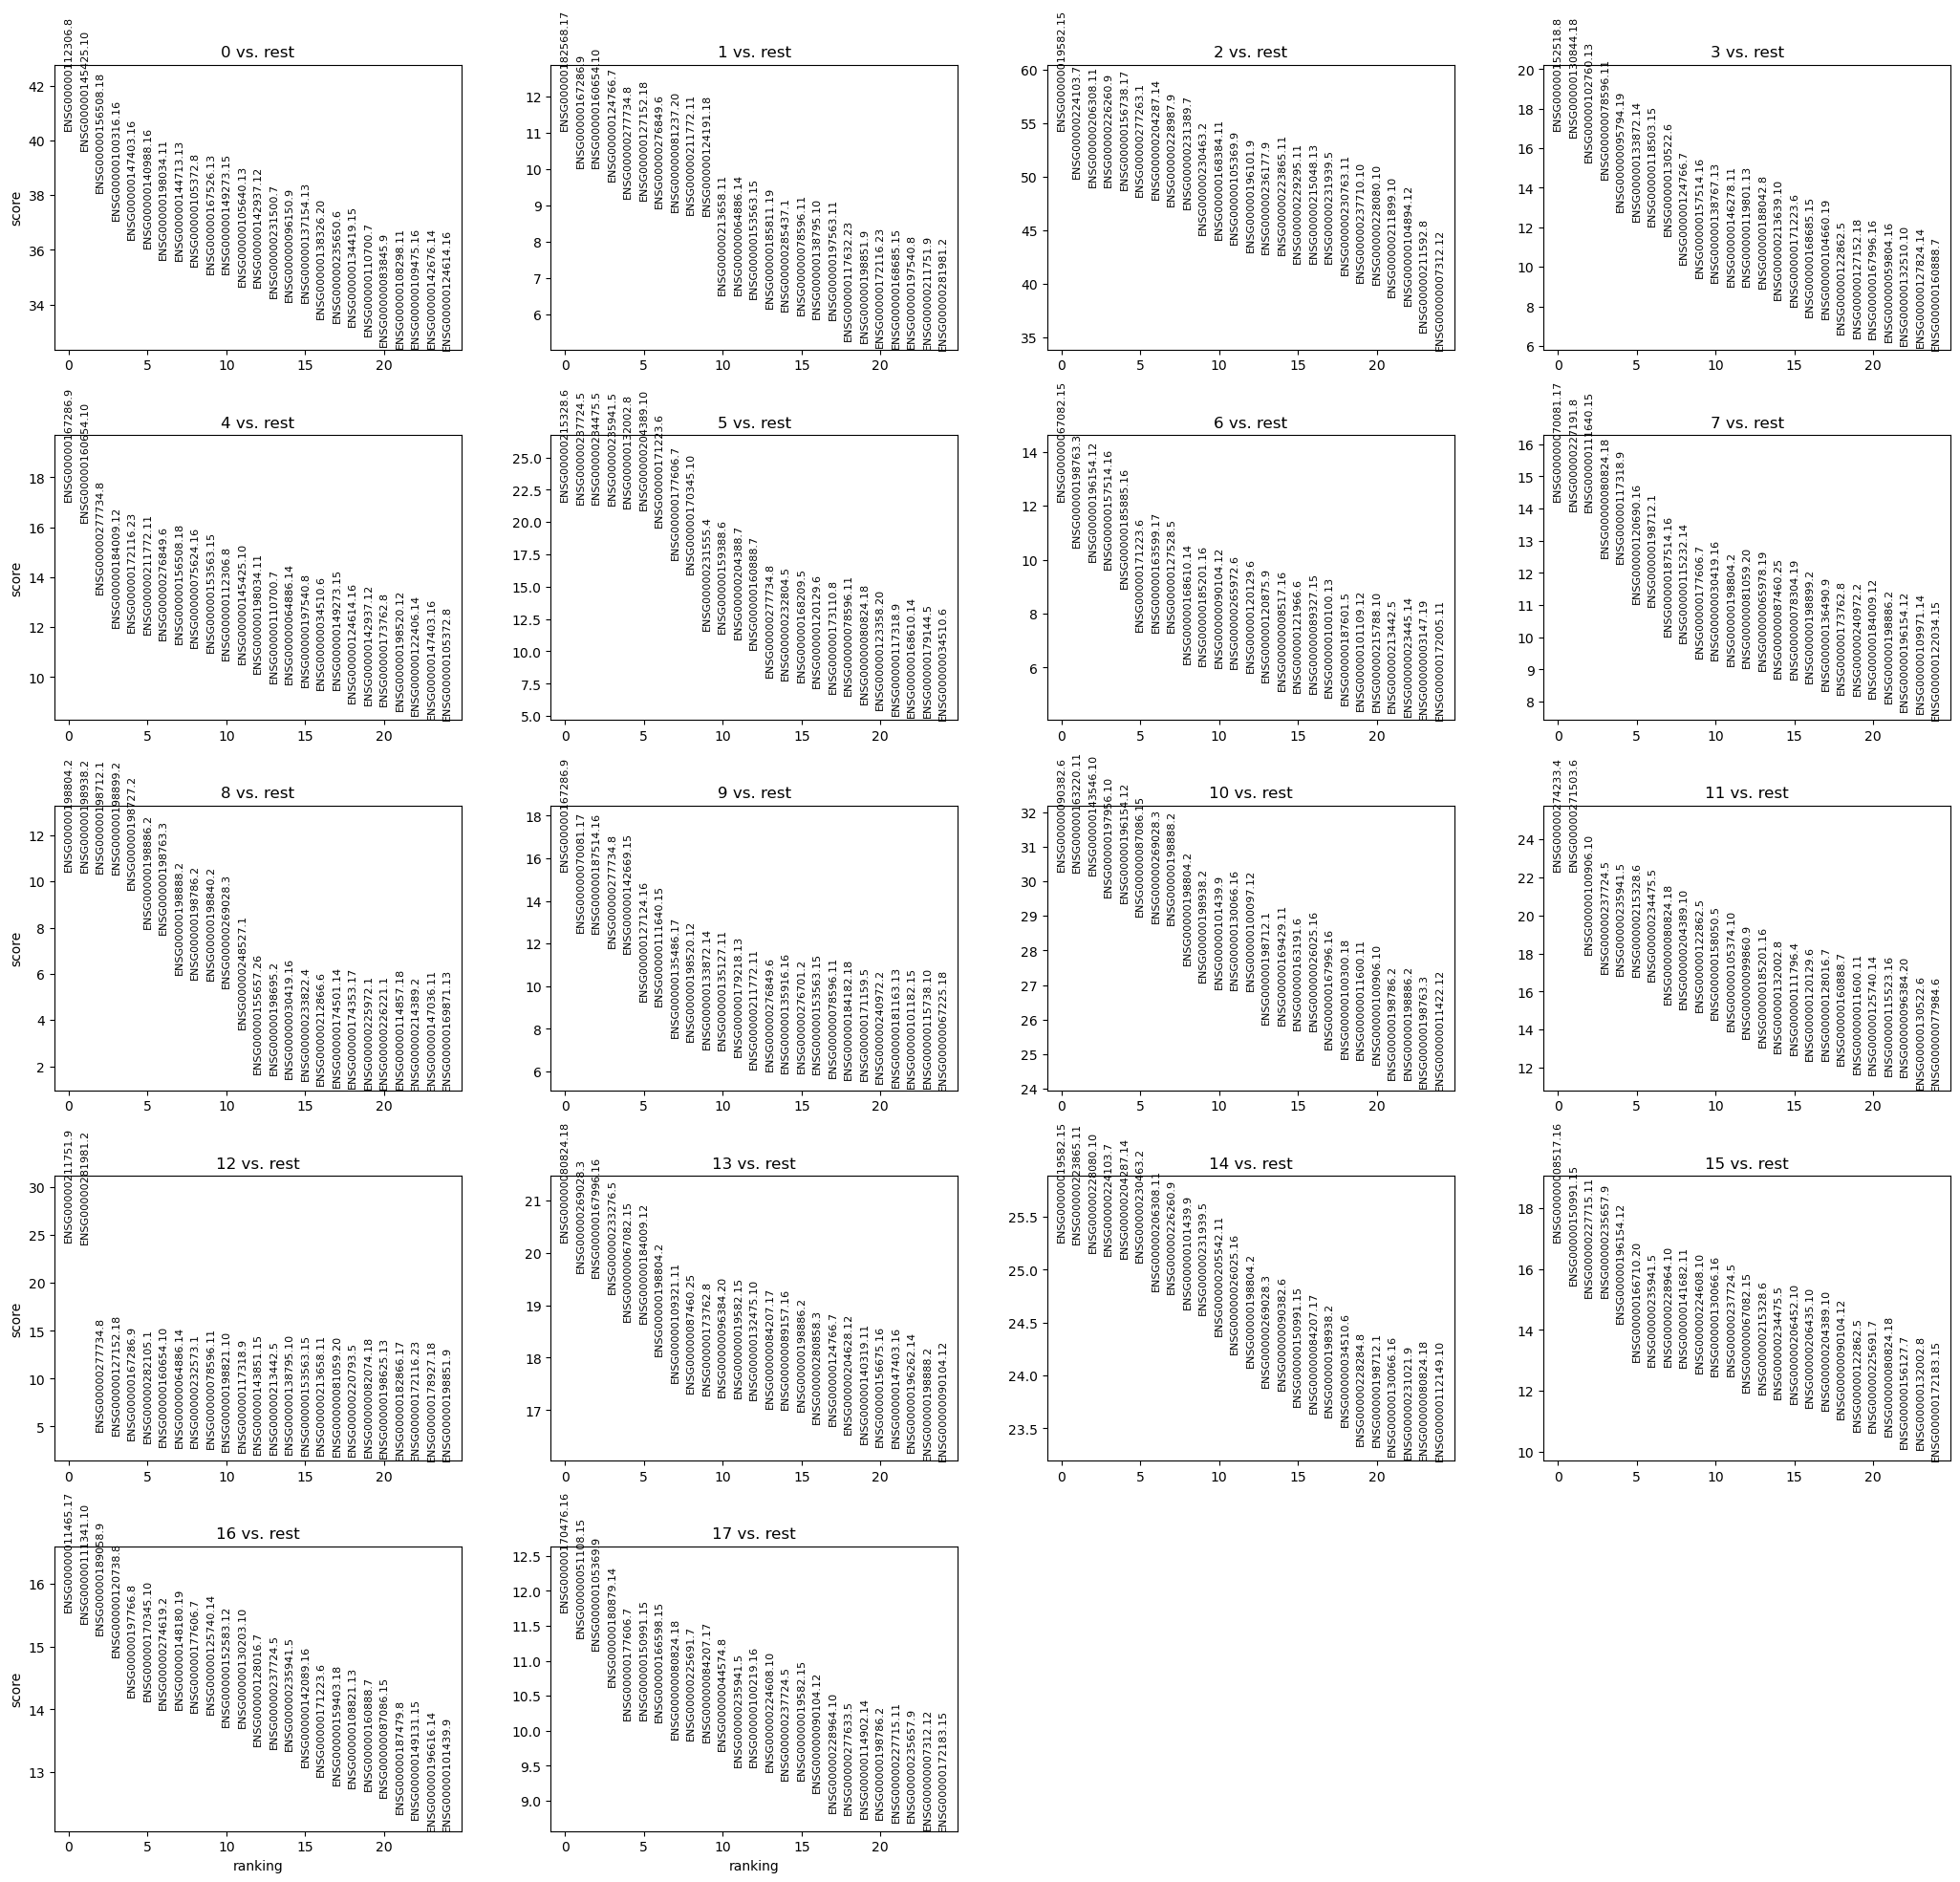

In [21]:
#   The result of a Wilcoxon rank-sum (Mann-Whitney-U) test is very similar.
# It is recommended using the latter in publications, see e.g., Sonison &
# Robinson (2018).
#
# Wilcoxon
sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon')

#    Rank genes for characterizing groups.
#
#    n_genes :  int (default: 20) is the number of genes to show.
#
#    sharey  : bool (default: True) Controls if the y-axis of each panels should
#              be shared. But passing sharey=False, each panel has its own y-axis range.
#
#    save    : save is a parameter to specify a string that will be appendeded to the default filename
#              rank_genes_groups_leiden of the plot.
#
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, save="_wilcoxon_plot.png")

# <span style="color:blue">Find marker genes per cluster using the </span><span style="color:red">logistic regression</span><span style="color:blue">.</span>

/opt/packages/anaconda3-2022.10/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


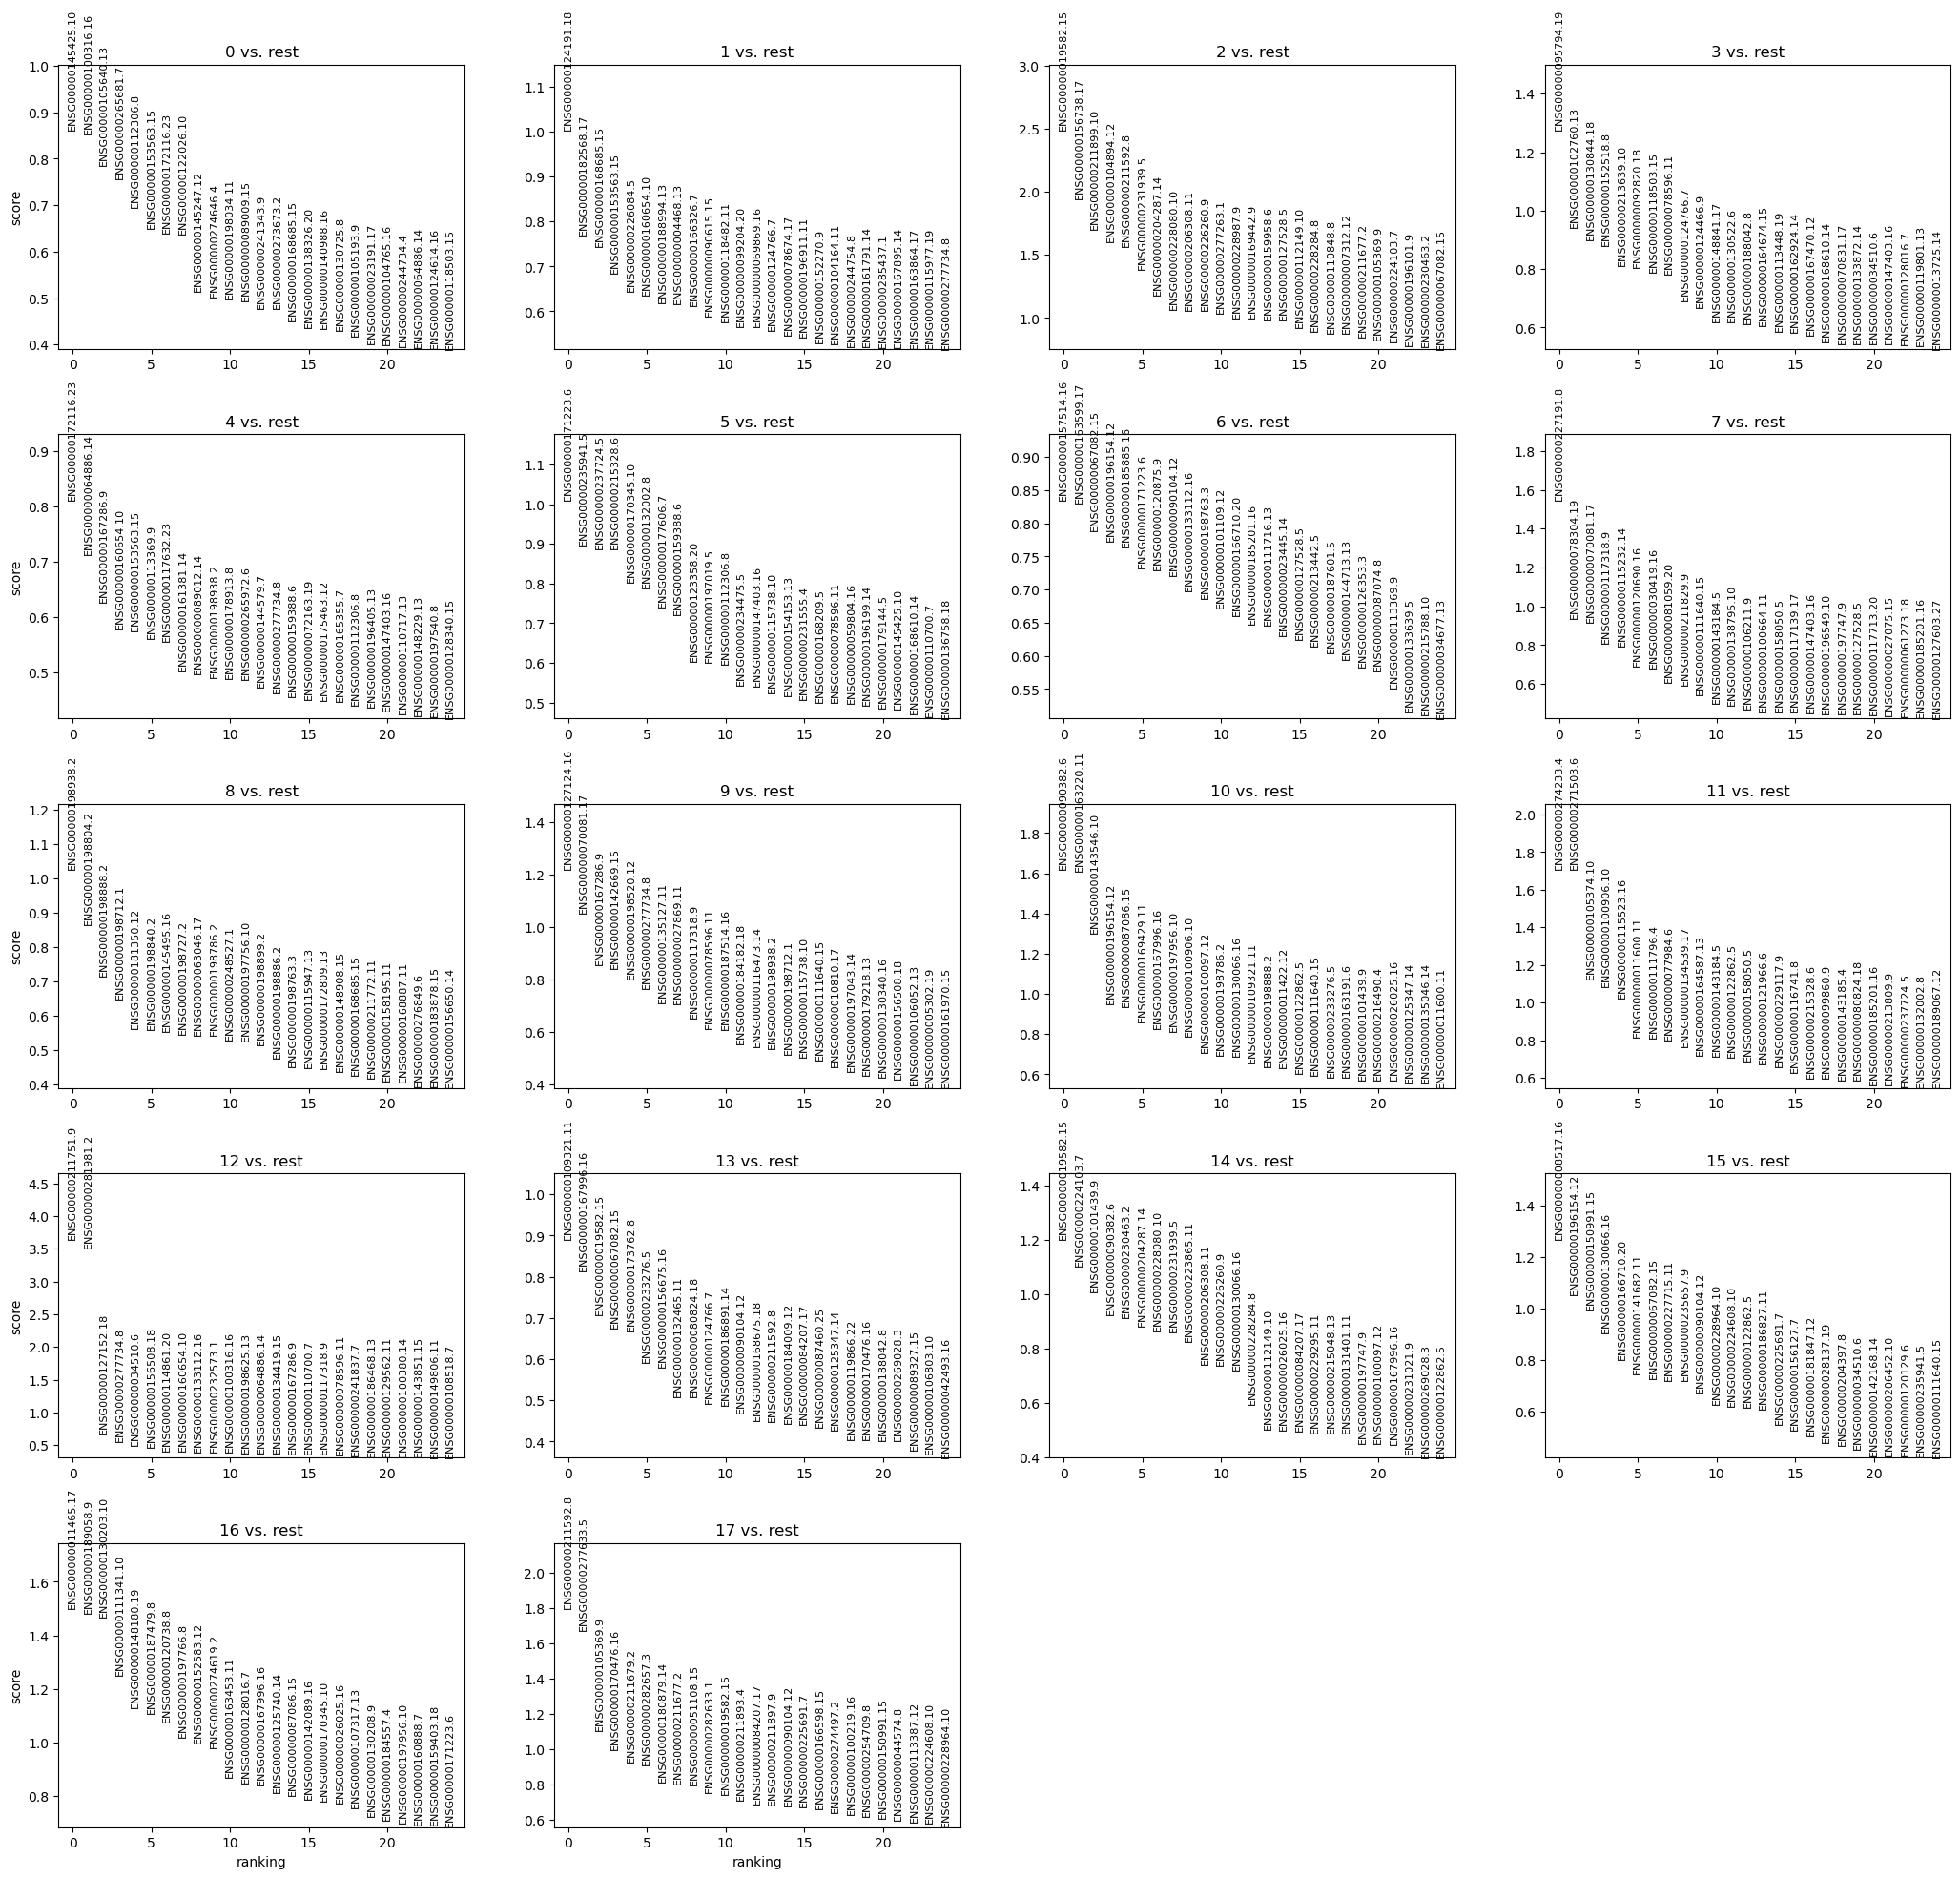

In [22]:
#   As an alternative, let us rank genes using logistic regression. For
# instance, this has been suggested by Natranos et al. (2018). The essential
# difference is that here, we use a multi-variate appraoch whereas conventional
# differential tests are uni-variate. Clark et al. (2014) has more details.
#
# Logistic regression
sc.tl.rank_genes_groups(adata, groupby='leiden', method='logreg')

#    Rank genes for characterizing groups.
#
#    n_genes :  int (default: 20) is the number of genes to show.
#
#    sharey  : bool (default: True) Controls if the y-axis of each panels should
#              be shared. But passing sharey=False, each panel has its own y-axis range.
#
#    save    : save is a parameter to specify a string that will be appendeded to the default filename
#              rank_genes_groups_leiden of the plot.
#
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, save="_logistic_regression_plot.png")

# <span style="color:blue">Now repeat the analysis to </span>
* ## <span style="color:blue">1) Find marker genes using  the </span><span style="color:red">Wilcoxon rank-sum (Mann-Whitney-U) </span>
## <span style="color:blue">2) Find marker genes using the </span><span style="color:red">logistic regression </span>
* ## <span style="color:blue">3) Compare the lists of marker genes per cluster reported by t-test, Wilcoxon rank-sum (Mann-Whitney-U), and logistic regression.</span>
* ## <span style="color:blue">4) Generate protein-protein interaction networks with </span><span style="color:red">Python's stringdb library HuBMAP's jupyter notebook</span><span style="color:blue">.</span>
* ## <span style="color:blue">5) Perform functional enrichment analysis with </span><span style="color:red">Python's stringdb library HuBMAP's jupyter notebook</span><span style="color:blue">.</span>
* ## <span style="color:blue">6) Perform Gene Ontology Enrichment Analysis (GOEA) with </span><span style="color:red">Python's goatools library HuBMAP's jupyter notebook</span><span style="color:blue">.</span>